In [1]:
!pip install shap xgboost

In [2]:
import numpy as np
import pandas as pd

#для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Модель линейной регрессии и с  Лассо-регуляризацией
from sklearn.linear_model import LinearRegression, LassoCV 

# Метрики MSE, коэффициент детерминации R2, MAE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Для деления на обучающую и валидационную выборки
from sklearn.model_selection import train_test_split

# Permutation feature importance (оценка важности признака)
from sklearn.inspection import permutation_importance

# Метод главных компонент
from sklearn.decomposition import PCA

# Shap-values для определения важности признаков
import shap

# Градиентный бустинг
from xgboost import XGBRFRegressor         

# Адаптивный бустинг и бэггинг
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

import scipy.stats
import statsmodels.api as sm

# ADD
from sklearn.feature_selection import SequentialFeatureSelector

# взаимная информация
from sklearn.feature_selection import mutual_info_regression

# кодирование категориальных признаков
from sklearn.preprocessing import OrdinalEncoder

# нормализация
from sklearn.preprocessing import StandardScaler

# игнорируем предудпреждения
import warnings
warnings.filterwarnings('ignore')

### Рассматривать различные методы будем наборе данных для прогнозирования стоимости машин

In [3]:
data = pd.read_csv('CarPrice_Assignment.csv')

##### Всего в данных 26 признаков для 205 объектов

In [4]:
print(data.shape)
data.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Предобработка

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

##### Пропусков в данных нет, ура. Удалим car_ID, смысла для модели в нем нет.

In [6]:
#удаление
data.drop(['car_ID'], axis = 1, inplace = True)

In [7]:
data

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,188.8,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


##### Выделим категориальные признаки и числовые

In [8]:
# метод select_dtypes возвращает подмножество столбцов фрейма данных на основе dtypes столбцов

categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
print(f"Всего категориальных признаков: {len(categorical_cols)}")

numeric_cols = data.select_dtypes(exclude=["object"]).columns.tolist()
print(f"Всего числовых признаков: {len(numeric_cols)}")

Всего категориальных признаков: 10
Всего числовых признаков: 15


In [9]:
#посмотрим, какое количество уникальных значений имеют категориальные признаки и числовые
unic_categ = pd.DataFrame([[i,data[i].nunique()] for i in categorical_cols], columns=['column_name','num_unique']).sort_values(by=['num_unique'])

In [10]:
#категориальные признаки
unic_categ

,column_name,num_unique
1,fueltype,2
2,aspiration,2
3,doornumber,2
6,enginelocation,2
5,drivewheel,3
4,carbody,5
7,enginetype,7
8,cylindernumber,7
9,fuelsystem,8
0,CarName,147


Почти все данные имеют уникальное значение CarName, посмотрим, что там

In [11]:
data.CarName.head(10) #имя в виде производитель + модель

0          alfa-romero giulia
1         alfa-romero stelvio
2    alfa-romero Quadrifoglio
3                 audi 100 ls
4                  audi 100ls
5                    audi fox
6                  audi 100ls
7                   audi 5000
8                   audi 4000
9         audi 5000s (diesel)
Name: CarName, dtype: object

Избавимся от модели, оставим только производителя в качестве категории

In [12]:
data['company'] = [i.split()[0] for i in data.CarName.values]

In [13]:
data.drop('CarName',axis=1,inplace=True)

In [14]:
categorical_cols.append('company')
categorical_cols.remove('CarName')

In [15]:
data.company.value_counts()

company
toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
peugeot        11
volvo          11
volkswagen      9
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
isuzu           4
porsche         4
alfa-romero     3
chevrolet       3
jaguar          3
vw              2
maxda           2
renault         2
toyouta         1
vokswagen       1
Nissan          1
mercury         1
porcshce        1
Name: count, dtype: int64

##### В компаниях есть опечатки, например vokswagen вместо volkswagen, избавимся от опечаток

In [16]:
data["company"] = data["company"].replace(
    {
        "maxda": "mazda",
        "porcshce": "porsche",
        "Nissan": "nissan",
        "vokswagen": "volkswagen",
        "vw": "volkswagen",
        "toyouta": "toyota",
      }
)
data["company"].value_counts()

company
toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: count, dtype: int64

In [17]:
unic_numer = pd.DataFrame([[i,data[i].nunique()] for i in numeric_cols], columns=['column_name','num_unique']).sort_values(by=['num_unique'])

In [18]:
#числовые признаки
unic_numer

,column_name,num_unique
0,symboling,6
11,peakrpm,23
12,citympg,29
13,highwaympg,30
9,compressionratio,32
8,stroke,37
7,boreratio,38
3,carwidth,44
6,enginesize,44
4,carheight,49


##### Для кодирования категорильных признаков используем OrdinalEncoder. 

Категориальные переменные необходимо закодировать. Существует множество вариантов кодирования, среди которых наиболее распространенными являются:
* [Порядковая кодировка](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Каждому новому значению признака присваивается новая метка. Обычно метки представляют собой числа от $0$ до $N –1$, где $N$ — количество уникальных значений признака. Поскольку принято обучать кодировщик на обучающей выборке, а тестовую выборку только изменять, может возникнуть ситуация, когда в тестовой выборке окажутся невстречающиеся ранее значения. Им присваивается новая переменная, например –1
* [Кодирование One-hot](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one+hot#sklearn.preprocessing.OneHotEncoder). Для каждого значения признака задается колонка, в которую проставляются $1$, если этот признак характерен для объекта, и $0$ в противном случае. Если поменять местами $1$ и $0$, то данный метод превратится кодирование в One-cold. Не очень подходит для признаков, которые имеют много уникальных значений, так как в результате получается очень разреженная матрица. 

In [19]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(data[categorical_cols])

data[categorical_cols] = encoder.transform(data[categorical_cols]).astype(int)

In [20]:
target_name = 'price' # будем прогнозировать стоиомость
numeric_cols.remove('price')

In [21]:
data.describe()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,company
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,0.902439,0.180488,0.439024,2.614634,1.326829,0.014634,98.756585,174.049268,65.907805,...,3.253659,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571,12.200000
std,1.245307,0.297446,0.385535,0.497483,0.859081,0.556171,0.120377,6.021776,12.337289,2.145204,...,2.013204,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332,6.286774
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.600000,141.100000,60.300000,...,0.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,94.500000,166.300000,64.100000,...,1.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000,7.000000
50%,1.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,97.000000,173.200000,65.500000,...,5.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000,12.000000
75%,2.000000,1.000000,0.000000,1.000000,3.000000,2.000000,0.000000,102.400000,183.100000,66.900000,...,5.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000,19.000000
max,3.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,120.900000,208.100000,72.300000,...,7.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000,21.000000


In [22]:
# Стандартизация
scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

In [23]:
data

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,company
0,1.743470,0.328798,-0.469295,1.130388,-3.050975,1.213330,-0.121867,-1.690772,-0.426521,-0.844782,...,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,0.027391,-1.945332
1,1.743470,0.328798,-0.469295,1.130388,-3.050975,1.213330,-0.121867,-1.690772,-0.426521,-0.844782,...,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,0.404461,-1.945332
2,0.133509,0.328798,-0.469295,1.130388,-0.717207,1.213330,-0.121867,-0.708596,-0.231513,-0.190566,...,0.869568,-2.404880,0.685946,-0.288349,1.264536,-0.262960,-0.953012,-0.691627,0.404461,-1.945332
3,0.938490,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,0.173698,0.207256,0.136542,...,0.869568,-0.517266,0.462183,-0.035973,-0.053668,0.787855,-0.186865,-0.109354,0.084485,-1.785879
4,0.938490,0.328798,-0.469295,-0.884652,0.449677,-2.391492,-0.121867,0.107110,0.207256,0.230001,...,0.869568,-0.517266,0.462183,-0.540725,0.275883,0.787855,-1.106241,-1.273900,0.523668,-1.785879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1.476452,0.328798,-0.469295,-0.884652,0.449677,1.213330,-0.121867,1.721873,1.198549,1.398245,...,0.869568,1.666445,-0.336970,-0.162161,0.250533,0.577692,-0.340094,-0.400490,0.447752,1.403191
201,-1.476452,0.328798,2.130854,-0.884652,0.449677,1.213330,-0.121867,1.721873,1.198549,1.351515,...,0.869568,1.666445,-0.336970,-0.364062,1.416637,0.367529,-0.953012,-0.837195,0.723810,1.403191
202,-1.476452,0.328798,-0.469295,-0.884652,0.449677,1.213330,-0.121867,1.721873,1.198549,1.398245,...,0.869568,0.926204,-1.232021,-0.338824,0.757535,0.787855,-1.106241,-1.128332,1.029983,1.403191
203,-1.476452,-3.041381,2.130854,-0.884652,0.449677,1.213330,-0.121867,1.721873,1.198549,1.398245,...,-0.126306,-1.183483,0.462183,3.244916,0.047732,-0.683286,0.119594,-0.546059,1.153582,1.403191


In [24]:
# разделим набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target_name, axis=1),
    data[target_name],
    test_size=0.25,
    random_state=41,
    shuffle=True
)

In [25]:
print('Размерность обучающей выборки: ',X_train.shape)
print()
print('Размерность тестовой выборки: ',X_test.shape)

Размерность обучающей выборки:  (153, 24)

Размерность тестовой выборки:  (52, 24)


## Одномерный отбор признаков
### Рассмотрим два метода: корреляцию Пирсона и взаимную информацию.

#### Коэффициент корреляции Пирсона
Коэффициент корреляции Пирсона рассчитывается по формуле 

$$r = \frac{\sum\left((x_i - \bar{x})(y_i - \bar{y})\right)}{\sqrt{\sum(x_i - \bar{x})^2 \cdot \sum(y_i - \bar{y})^2}}$$

и показывает силу линейной зависимости между двумя случаными величинами. Силу зависимости можно охарактеризовать, используя **шкалу Чеддока**. 
<img src="Шкала Чеддока.png" alt="drawing" width="600"/>

Коэффициент корреляции максимален по модулю, если между признаком и целевой переменной есть линейная связь. Это означает, что корреляция измеряет только линейную информативность, то есть способность признака линейно предсказывать целевую переменную.

Ограничения метода:
* Коэффициент корреляции Пирсона пригоден для выявления только линейных зависимостей.
* Оценки значимости и доверительного интервала оправданы тогда, когда данные в генеральной совокупности распределены нормально.
* При помощи корреляционного анализа нельзя сказать, что является причиной, а что следствием!

#### Взаимная информация
Взаимная информация во многом похожа на корреляцию в том смысле, что она измеряет взаимосвязь между двумя величинами. Преимущество взаимной информации заключается в том, что она может обнаруживать любые виды взаимосвязей, в то время как корреляция обнаруживает только линейные взаимосвязи.
Взаимная информация (MI) между двумя величинами является мерой степени, в которой знание одной величины уменьшает неопределенность относительно другой или мера степени с которой одна случайная величина содержит информацию о другой случайной величине.

Неопределенность измеряется с использованием величины из теории информации, известной как "энтропия". 
Энтропия случайной величины − это мера ее неопределенности и мера среднего количества информации, необходимой для описания случайной величины.
Большая взаимная информация означает высокую значимость признака. То есть она показывает насколько чётко определена целевая переменная, если известны значения признака. Чем выше значение, тем сильнее связь.
Реализован в sklearn как [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) и [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) соответственно для регрессии и классификации.

##### Методы одномерного отбора признаков не учитывают взаимосвязи между признаками, так как важность каждого признака оценивается отдельно, независимо от других признаков. Один признак может быть важен, но только в совокупности с другим признаком.


#### Посмотрим, какая есть линейная зависимость между стоимостью машины и остальными признаками

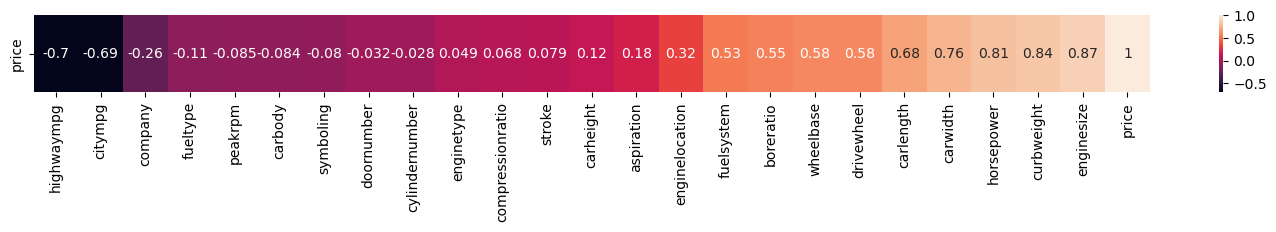

In [26]:
plt.figure(figsize = (18,1))
sns.heatmap(pd.DataFrame(data.corr().price.sort_values()).T, annot = True)
plt.show()

In [27]:
print('Самая высокая линейная зависимость с price у признаков:')
features_lin = data.corr().price[abs(data.corr().price) > 0.3][:-1]
print(features_lin)

Самая высокая линейная зависимость с price у признаков:
drivewheel        0.577992
enginelocation    0.324973
wheelbase         0.577816
carlength         0.682920
carwidth          0.759325
curbweight        0.835305
enginesize        0.874145
fuelsystem        0.526823
boreratio         0.553173
horsepower        0.808139
citympg          -0.685751
highwaympg       -0.697599
Name: price, dtype: float64


#### Используем взаимную информацию

In [28]:
res_MI = pd.Series(mutual_info_regression(data.drop(target_name, axis=1), data[target_name]),index=data.drop(target_name, axis=1).columns)
print('Самая высокая взаимная информация с price у признаков:')
features_MI = res_MI.sort_values()[-12:]
print(features_MI)

Самая высокая взаимная информация с price у признаков:
carheight     0.340234
stroke        0.367474
boreratio     0.447322
fuelsystem    0.464818
carlength     0.565378
wheelbase     0.572445
carwidth      0.679292
citympg       0.741827
enginesize    0.823309
horsepower    0.855831
curbweight    0.860386
highwaympg    0.861183
dtype: float64


In [29]:
# функция для получения метрик
def score (x, y, model):
    pred = model.predict(x)
    r2 = r2_score(y, pred)
    return (round(r2, 4))

In [30]:
set(res_MI.sort_values()[-7:].index) & set(data.corr().price[abs(data.corr().price) > 0.6][:-1].index)

{'carwidth', 'citympg', 'curbweight', 'enginesize', 'highwaympg', 'horsepower'}

#### Обучим линейную регрессиию на обоих результатах. Возьмем по 12 самых важных признаков.

In [31]:
np.random.seed(42)
model_lr_lin = LinearRegression()
model_lr_MI = LinearRegression()

model_lr_lin.fit(X_train[list(features_lin.index)], y_train)
model_lr_MI.fit(X_train[list(features_MI.index)], y_train)

print("На тестовой выборке по корреляции Пирсона")
print(f"R2: {score(X_test[list(features_lin.index)],y_test,model_lr_lin)}")
print()
print("На тестовой выборке по взаимной информации")
print(f"R2: {score(X_test[list(features_MI.index)],y_test,model_lr_MI)}")

На тестовой выборке по корреляции Пирсона
R2: 0.7578

На тестовой выборке по взаимной информации
R2: 0.7064


#### Перебор
Самый простой способ – это полный перебор всех подмножеств признаков и оценивание качества модели на каждом подмножестве. Итоговое подмножество – то, на котором качество модели наилучшее.
Перебирать подмножества можно последовательно: сначала те, которые имеют мощность 1 (наборы из 1 признака), потом наборы мощности 2, и так далее. Этот хорош тем, что он найдет оптимальное подмножество признаков. При этом очень и очень долгий, поскольку всего таких подмножеств много. Если признаков сотни или тысячи, то такой перебор невозможен. Он займет слишком много времени, возможно, сотни лет или больше. Поэтому такой метод подходит при небольшом количестве признаков.


## Методы отбора признаков, основанные на жадных алгоритмах

Жадные методы отбора признаков, по сути своей, являются надстройками над методами обучения моделей. 
Данный процесс построен на том, что обучение модели считается черным ящиком, который на вход принимает информацию о том, какие признаки можно использовать, обучается модель, и дальше каким-то методом оценивается качество такой модели.

Жадные методы потому, что мы не проверяем качество на всех комбинациях признаков, а только лишь локально оптимизируем, варьируя добавляемый признак.
Нет гарантии, что подобранная комбинация признаков глобально оптимальна, но это хоть что-то.


#### Жадное добавление или удаление (forward / backward selection)
Если же признаков много, то можно применять жадную стратегию. Жадная стратегия используется, когда полный перебор не подходит для решения задачи. Например, может оказаться неплохой стратегия жадного наращивания (жадного добавления). Сначала находится один признак, который дает наилучшее качество модели (наименьшую ошибку модели). 
Наиболее значимая переменная может быть выбрана таким образом, чтобы при добавлении в модель: она имеет наименьшее значение p-value, или наибольшее значение коэффициента корреляции Пирсона, или обеспечивает наибольшее увеличение R2, или наибольшее снижение RSS модели (суммы квадратов остатков) по сравнению с другими рассматриваемыми признаками.

Дальше к этому множеству добавляется еще один признак так, чтобы как можно сильнее уменьшить ошибку модели. так каждый раз добавляется по одному признаку, образуются различные подмножества. Если в какой-то момент невозможно добавить новый признак так, чтобы уменьшить ошибку, процедура останавливается. 
Правило остановки выполняется, когда все остальные рассматриваемые переменные имеют p-значение, большее некоторого заданного порога, если оно добавлено в модель. Когда мы достигнем этого состояния, прямой выбор завершится и вернет модель, которая содержит только переменные с p-значениями < порогового значения.

Жадное удаление (или обратное исключение) – это метод отбора переменных, начинающийся с модели, которая содержит все рассматриваемые признаки. Затем начинается удаление наименее значимых признаков один за другим до достижения заранее указанного критерия остановки или до тех пор, пока в модели не останется ни одного признака.

В отличие от backward selection, forward selection может использоваться, когда количество рассматриваемых признаков очень велико.
Это связано с тем, что прямой отбор начинается с нулевой модели (без признаков) и продолжается добавлением переменных по одной за раз, и поэтому, в отличие от обратного отбора, при нем не обязательно учитывать полную модель (которая включает все признаки).

Преимущество использования полной модели заключается в одновременном рассмотрении влияния всех признаков.
Когда данных не так много и признаков не так много, то лучше использовать DEL.


#### ADD-DEL (forward-backward selection)
Добавление и удаление признаков до тех пор, пока уменьшается ошибка.
Жадный алгоритм довольно быстрый: в нем столько итераций, сколько признаков в выборке. Но при этом он перебирается слишком мало вариантов. Процедуру можно усложнить. Один из подходов к усложнению – это алгоритм ADD-DEL, который не только добавляет, но и удаляет признаки из оптимального множества. Алгоритм начинается с процедуры жадного добавления. Каждый раз, когда добавляется новый признак, нужно проверить, следует ли исключить какие-либо другие признаки ,которые уже есть в модели. Удаляется тот признак, который приводит к наибольшему уменьшению ошибки на выборке. Эта процедура повторяет добавление и удаление признаков до тех пор, пока уменьшается ошибка. Алгоритм ADD-DEL всё еще жадный, но при этом он менее жадный, чем предыдущие, поскольку может исправлять ошибки, сделанные в начале перебора: если вначале был добавлен неинформативный признак, то на этапе удаления от него можно избавиться.

In [32]:
#ADD
model_lin_reg_ADD = LinearRegression()
model_lin_reg_ADD.fit(X_train, y_train)
sfs_forward = SequentialFeatureSelector(model_lin_reg_ADD, n_features_to_select='auto',direction='forward')
sfs_forward.fit(X_train, y_train)
sfs_forward_feat = sfs_forward.feature_names_in_[sfs_forward.get_support()]
print(f'Всего отобранных признаков {len(sfs_forward_feat)} с помощью forward-selection:')
print(sfs_forward_feat)
print()

#DEL
model_lin_reg_DELL = LinearRegression()
model_lin_reg_DELL.fit(X_train, y_train)
sfs_backward = SequentialFeatureSelector(model_lin_reg_DELL, n_features_to_select='auto',direction='backward')
sfs_backward.fit(X_train, y_train)
sfs_backward_feat = sfs_backward.feature_names_in_[sfs_backward.get_support()]
print(f'Всего отобранных признаков {len(sfs_backward_feat)} с помощью backward-selection:')
print(sfs_backward_feat)
print()

Всего отобранных признаков 12 с помощью forward-selection:
['symboling' 'fueltype' 'aspiration' 'carbody' 'enginelocation' 'carwidth'
 'curbweight' 'enginesize' 'stroke' 'compressionratio' 'peakrpm' 'company']

Всего отобранных признаков 12 с помощью backward-selection:
['symboling' 'aspiration' 'carbody' 'enginelocation' 'carwidth'
 'carheight' 'enginesize' 'stroke' 'compressionratio' 'peakrpm' 'citympg'
 'company']



#### Посмотрим на метрики линейной регрессии по результатам каждого метода

In [33]:
np.random.seed(42)
model_lr_ADD = LinearRegression()
model_lr_DELL = LinearRegression()

model_lr_ADD.fit(X_train[sfs_forward_feat], y_train)
model_lr_DELL.fit(X_train[sfs_backward_feat], y_train)

print("На тестовой выборке ADD")
print(f"R2: {score(X_test[sfs_forward_feat], y_test, model_lr_ADD)}")
print()
print("На тестовой выборке DELL")
print(f"R2: {score(X_test[sfs_backward_feat], y_test, model_lr_DELL)}")

На тестовой выборке ADD
R2: 0.7634

На тестовой выборке DELL
R2: 0.7744


На признаках, полученных с помощью жадных алгоритмов, результат лучше, хотя количество признаков такое же, какое и было получено с помощью одномерного отбора

## Отбор признаков на основе моделей
#### Для начала посмотрим на линейные модели
Мы можем оценить значимость признаков на основе построенной линейной модели в том случае, если признаки были нормализованы. Тогда веса полученной модели будут указывать на важность признака, чем больше модуль веса модели у соответствующего признака, тем больше этот признак влияет на результат работы модели.

Если для линейной модели признаки не нормализованы, то тогда необходимо оценивать значимость признаков другим способом, например, построить доверительные интервалы для каждого коэффициента перед признаками. Можно это сделать используя linear regression в statsmodels. Если 0 входит в доверительный интервал, то признак не значим. Также можно отсортировать по p-value, чем он меньше выбранного уровня значимости, тем более значим признак.

Отобрать признаки можем также с помощью Lasso-регрессии. Например, можно сначала сделать отбор признаков с помощью Lasso, а затем оценить параметры модели заново с помощью Ridge-регрессии, используя отобранные признаки. Или ElasticNet, где присутствует и Lasso и Ridge регуляризация.

In [34]:
X_train

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,company
160,-0.671472,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,-0.508831,-0.629655,-0.704593,...,-0.695874,-1.122179,-0.517266,-0.720563,-0.288349,-0.864871,-0.683286,1.958346,2.365308,1.084284
142,-0.671472,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,-0.259126,-0.166510,-0.237296,...,-0.455148,-1.122179,1.074252,-1.967242,-0.162161,-0.560670,-1.523939,0.426052,0.327351,0.924830
182,0.938490,-3.041381,-0.469295,1.130388,0.449677,-0.589081,-0.121867,-0.242478,-0.190886,-0.190566,...,-0.719947,-0.126306,-1.183483,0.462183,3.244916,-1.321172,-0.683286,1.805116,2.219739,1.243737
155,-0.671472,0.328798,-0.469295,-0.884652,1.616562,-2.391492,-0.121867,-0.508831,-0.353393,-1.078431,...,-0.840310,-1.122179,-1.035435,-0.720563,-0.288349,-1.067671,-0.683286,0.272823,0.181783,1.084284
110,-0.671472,-3.041381,2.130854,-0.884652,1.616562,1.213330,-0.121867,2.570873,2.019209,1.164596,...,0.604046,-0.126306,1.370348,0.845777,2.740164,-0.231119,-2.049347,-0.033636,-0.837195,0.127563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.671472,0.328798,-0.469295,-0.884652,0.449677,1.213330,-0.121867,1.022697,0.077250,0.089812,...,0.315175,0.869568,1.592421,-0.305004,-0.540725,0.402634,-0.262960,-0.953012,-0.546059,-0.510251
80,1.743470,0.328798,2.130854,1.130388,-0.717207,-0.589081,-0.121867,-0.408949,-0.085257,-0.237296,...,-0.407003,1.367504,-0.591290,0.653980,-0.666913,0.301233,0.787855,-0.340094,-0.109354,-0.191344
140,0.938490,0.328798,-0.469295,1.130388,-0.717207,-2.391492,-0.121867,-0.908360,-1.360937,-0.984972,...,-0.455148,-1.122179,1.074252,-1.967242,-0.364062,-0.788820,-1.523939,0.119594,0.036215,0.924830
163,0.133509,0.328798,-0.469295,1.130388,0.449677,1.213330,-0.121867,-0.708596,-0.434647,-0.891512,...,-0.695874,-1.122179,-0.517266,-0.720563,-0.288349,-0.864871,-0.683286,0.579282,0.472920,1.084284


Библиотека sm.OLS для построения модели линейной регрессии очень удобна, она выводит сразу всю инфмормацию по полученным результатам, разные полезные статистики, так же p-уровни значимости для каждого признака и доверительные интервалы.

Для того, чтобы запустить модель, нужно добавить константный признак в модель, sklearn делает это автоматически, statsmodels нет.

In [35]:
X_train_const = sm.add_constant(pd.DataFrame(X_train), prepend = False)
X_test_const = sm.add_constant(pd.DataFrame(X_test), prepend = False)

In [36]:
X_train_const

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,company,const
160,-0.671472,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,-0.508831,-0.629655,-0.704593,...,-1.122179,-0.517266,-0.720563,-0.288349,-0.864871,-0.683286,1.958346,2.365308,1.084284,1.0
142,-0.671472,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,-0.259126,-0.166510,-0.237296,...,-1.122179,1.074252,-1.967242,-0.162161,-0.560670,-1.523939,0.426052,0.327351,0.924830,1.0
182,0.938490,-3.041381,-0.469295,1.130388,0.449677,-0.589081,-0.121867,-0.242478,-0.190886,-0.190566,...,-0.126306,-1.183483,0.462183,3.244916,-1.321172,-0.683286,1.805116,2.219739,1.243737,1.0
155,-0.671472,0.328798,-0.469295,-0.884652,1.616562,-2.391492,-0.121867,-0.508831,-0.353393,-1.078431,...,-1.122179,-1.035435,-0.720563,-0.288349,-1.067671,-0.683286,0.272823,0.181783,1.084284,1.0
110,-0.671472,-3.041381,2.130854,-0.884652,1.616562,1.213330,-0.121867,2.570873,2.019209,1.164596,...,-0.126306,1.370348,0.845777,2.740164,-0.231119,-2.049347,-0.033636,-0.837195,0.127563,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.671472,0.328798,-0.469295,-0.884652,0.449677,1.213330,-0.121867,1.022697,0.077250,0.089812,...,0.869568,1.592421,-0.305004,-0.540725,0.402634,-0.262960,-0.953012,-0.546059,-0.510251,1.0
80,1.743470,0.328798,2.130854,1.130388,-0.717207,-0.589081,-0.121867,-0.408949,-0.085257,-0.237296,...,1.367504,-0.591290,0.653980,-0.666913,0.301233,0.787855,-0.340094,-0.109354,-0.191344,1.0
140,0.938490,0.328798,-0.469295,1.130388,-0.717207,-2.391492,-0.121867,-0.908360,-1.360937,-0.984972,...,-1.122179,1.074252,-1.967242,-0.364062,-0.788820,-1.523939,0.119594,0.036215,0.924830,1.0
163,0.133509,0.328798,-0.469295,1.130388,0.449677,1.213330,-0.121867,-0.708596,-0.434647,-0.891512,...,-1.122179,-0.517266,-0.720563,-0.288349,-0.864871,-0.683286,0.579282,0.472920,1.084284,1.0


#### Обучим модель линейной регрессии из библиотеки sklearn на всех данных

In [37]:
np.random.seed(42)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print("На обучающей выборке")
print(f"R2: {score(X_train,y_train,model_lr)}")
print()
print("На тестовой выборке")
print(f"R2: {score(X_test,y_test,model_lr)}")

На обучающей выборке
R2: 0.9141

На тестовой выборке
R2: 0.7445


#### Обучим модель линейной регрессии из библиотеки statsmodels

In [38]:
model = sm.OLS(y_train.values.reshape(-1,1), X_train_const)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     56.78
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           1.07e-56
Time:                        18:34:44   Log-Likelihood:                -39.573
No. Observations:                 153   AIC:                             129.1
Df Residuals:                     128   BIC:                             204.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
symboling           -0.0612      0.050  

#### В результате получаем полную информацию о модели, сейчас нас интересуют признаки и их p-value или доверительные интервалы. Если p-value меньше 0.05, то нулевая гипотеза о равенстве параметра нулю отбрасывается. Для таких признаков доверительный интервал веса не будет содержать в себе значение 0.

In [39]:
# отсортируем p-value
res_p = res.pvalues.sort_values()
print(res_p)

enginesize          6.072091e-07
company             6.304656e-07
enginelocation      9.177652e-06
stroke              1.808498e-03
carwidth            1.220282e-02
carbody             1.282112e-02
peakrpm             3.864932e-02
highwaympg          9.225955e-02
aspiration          1.325868e-01
cylindernumber      1.335161e-01
curbweight          1.843788e-01
citympg             2.209605e-01
symboling           2.264046e-01
compressionratio    2.438353e-01
fueltype            3.240428e-01
carheight           3.977283e-01
fuelsystem          4.155958e-01
wheelbase           5.198011e-01
drivewheel          5.309375e-01
const               5.554819e-01
enginetype          6.365062e-01
doornumber          6.696632e-01
carlength           8.429155e-01
boreratio           9.115329e-01
horsepower          9.320381e-01
dtype: float64


#### По мнению линейной регрессии топ 5 самых важных признаков: enginesize, company, enginelocation, stroke, carwidth.

#### Посомотрим, как меняется метрика, если последовательно отправлять в модель признаки, начиная с самого важного.

In [40]:
scores_train = list()
scores_test = list()
for i in range (1,len(res_p)+1):
    X = X_train_const[res_p.index[:i]]
    X_t = X_train_const[res_p.index[:i]]
    np.random.seed(42)

    model = sm.OLS(y_train.values.reshape(-1,1),X)
    score_train = model.fit().rsquared
    
    scores_train.append(round(score_train,4))

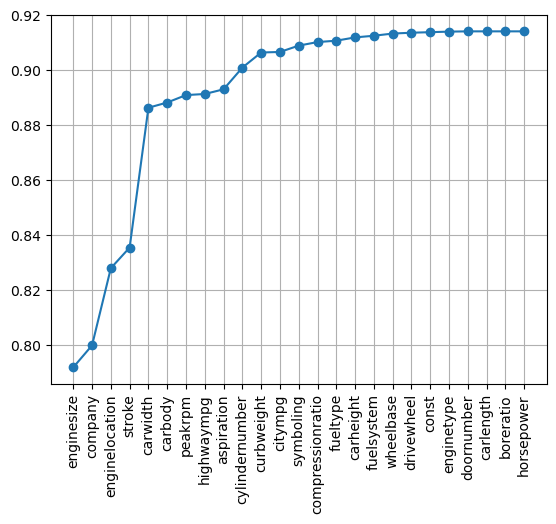

In [41]:
plt.grid()
plt.plot(list(res_p.index),scores_train, '-o')
plt.xticks(rotation = 90)
plt.show()

#### Наибольший вклад дают самые важные признаки, после wheelbase прирост коэффициента детерминации небольшой.

### Далее посмотрим, что думает линейная регрессия с Lasso регуляризацией
#### Параметр регуляризации подбираем с помощью кросс-валидации

In [42]:
np.random.seed(42)
model_lasso = LassoCV(alphas=np.arange(0,1,0.001))
model_lasso.fit(X_train, y_train)
print('Параметр регуляризации: ', model_lasso.alpha_)
print()
print("На обучающей выборке")
print(f"R2: {score(X_train,y_train,model_lasso)}")
print()
print("На тестовой выборке")
print(f"R2: {score(X_test,y_test,model_lasso)}")

Параметр регуляризации:  0.004

На обучающей выборке
R2: 0.9118

На тестовой выборке
R2: 0.7837


In [43]:
lasso_reg = pd.Series(np.abs(np.append(model_lasso.coef_,model_lasso.intercept_)), index = np.append(model_lasso.feature_names_in_,'const'))
lasso_param = lasso_reg.sort_values()
lasso_param

fueltype            0.000000
citympg             0.000000
doornumber          0.000000
boreratio           0.000000
enginetype          0.013383
const               0.015824
carlength           0.017986
aspiration          0.018926
fuelsystem          0.030802
carheight           0.032375
symboling           0.035269
drivewheel          0.044962
highwaympg          0.046549
cylindernumber      0.049315
wheelbase           0.049633
compressionratio    0.056834
horsepower          0.063547
peakrpm             0.092146
carbody             0.101288
stroke              0.110950
curbweight          0.129202
enginelocation      0.161834
company             0.170214
carwidth            0.221441
enginesize          0.510685
dtype: float64

#### Lasso-регрессия считает, что на стоимость машины никак не влияет тип топлива, расход топлива в городе, количество дверей и соотношение между диаметром цилиндра и ходом поршня.
#### А самые важные признаки: размер двигателя, ширина машины, компания, положение двигателя и масса транспортного средства

### Посмотрим на ансамблевые модели

Для ансамблей решающих деревьев признак тем более важен, чем чаще он встречается в ветвлениях (если нет бинарных или признаков с малым количеством категорий), например:

<img src="Пример дерева решений.png" alt="drawing" width="600"/>

##### Встречаемость признаков в ветвлениях: 
* AveRooms  5 раз
* Population  4 раза 
* AveBedrms  1 раз

Для данного дерева наиболее важным является признак AveRooms. 

В ансамбле содержится не одно дерево, а множество деревьев, можно получить количество вхождений в узлы каждого признака для каждого дерева, а затем сагрегировать полученные значения.

Данный метод считает более важными непрерывные признаки, чем бинарные или признакам с малым количеством категорий. Чтобы убрать данный недостаток, был введен алгоритм оценки важности признаков *permutation feature importance*.

**permutation feature importance**
* Обучаем модель
* Проверяем на тестовой выборке (получаем ошибку **Q**)
* В той же тестовой выборке перемешиваем оцениваемый признак и снова проверяем модель (получаем ошибку **Q'**) 
* **(Q'-Q)** определяет важность признака. Чем ниже падает качество, тем признак важнее

Есть модель, обученная на обучающей выборке.
Эту модель мы проверяем на тестовой выборке и получаем значение метрики.
Далее берется тот же тестовый набор данных и для того, чтобы оценить значимость признака, этот признак перемешивается. То есть распределение остается прежним, но значения его для конкретный объектов уже не имеют смысла. На полученной тестовой выборке снова оцениваем качество модели. 
Если качество модели сильно упало, значит признак был важен. Если качество не изменилось, то признак моделью особо не учитывался.

В ансамбле деревьев каждое дерево получает свое подмножество исходных объектов, объекты, которые не включены в подмножество для определенного дерева, называются объектами вне пакета (out-of-bag, OOB). Так как объекты OOB не использовались для обучения конкретного дерева, их можно использовать для оценки качества этого дерева. Ошибка OOB вычисляется путем сравнения предсказанных значений для выборок OOB с их целевыми значениями. Для каждого дерева рассчитывается OOB ошибка, с использованием алгоритма оценки важности признаков.

Для ансамбля деревьев полученные значения **(Q'-Q)** усредняют по всем деревьям случайного леса.

Если признаки были скореллированы, то значимость между ними поделиться, даже если они очень важны, мы можем этого не увидеть.
Если для категориальных признаков используется one-hot кодирование, то значимость также уменьшается, делится между значениями категорий.

#### Обучим линейную модель, градиентный бустинг и случайный лес.

In [44]:
np.random.seed(42)

model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train, y_train)
results = [score(X_test,y_test,model_linear_regression)]

model_xdb = XGBRFRegressor(device= "cpu", output_margin=True).fit(X_train, y_train)
results.append(score(X_test,y_test,model_xdb))

model_forest = RandomForestRegressor().fit(X_train, y_train)
results.append(score(X_test,y_test,model_forest))

results.append(score(X_test,y_test,model_lasso))

In [45]:
results = pd.DataFrame(results,index=['LinearRegression','XGBRFRegressor','RandomForestRegressor', 'LassoRegression'], columns=['R2'])

In [46]:
print(results.sort_values('R2'))

                           R2
LinearRegression       0.7445
LassoRegression        0.7837
XGBRFRegressor         0.8581
RandomForestRegressor  0.8931


#### Вытащим из моделей самые важные признаки с помощью метода feature_importances_, а также найжем важность признаков с помощью permutation_importance у случайного леса

In [47]:
predictors_model_xdb =  pd.Series(model_xdb.feature_importances_, index=model_xdb.feature_names_in_)

predictors_forest =  pd.Series(model_forest.feature_importances_, index=model_forest.feature_names_in_)

result_perm_imp = permutation_importance(model_forest, X_train, y_train, n_repeats=10, random_state=42, scoring = 'neg_mean_squared_error')
predictors_forest_PI =  pd.Series(result_perm_imp.importances_mean, index=model_forest.feature_names_in_)

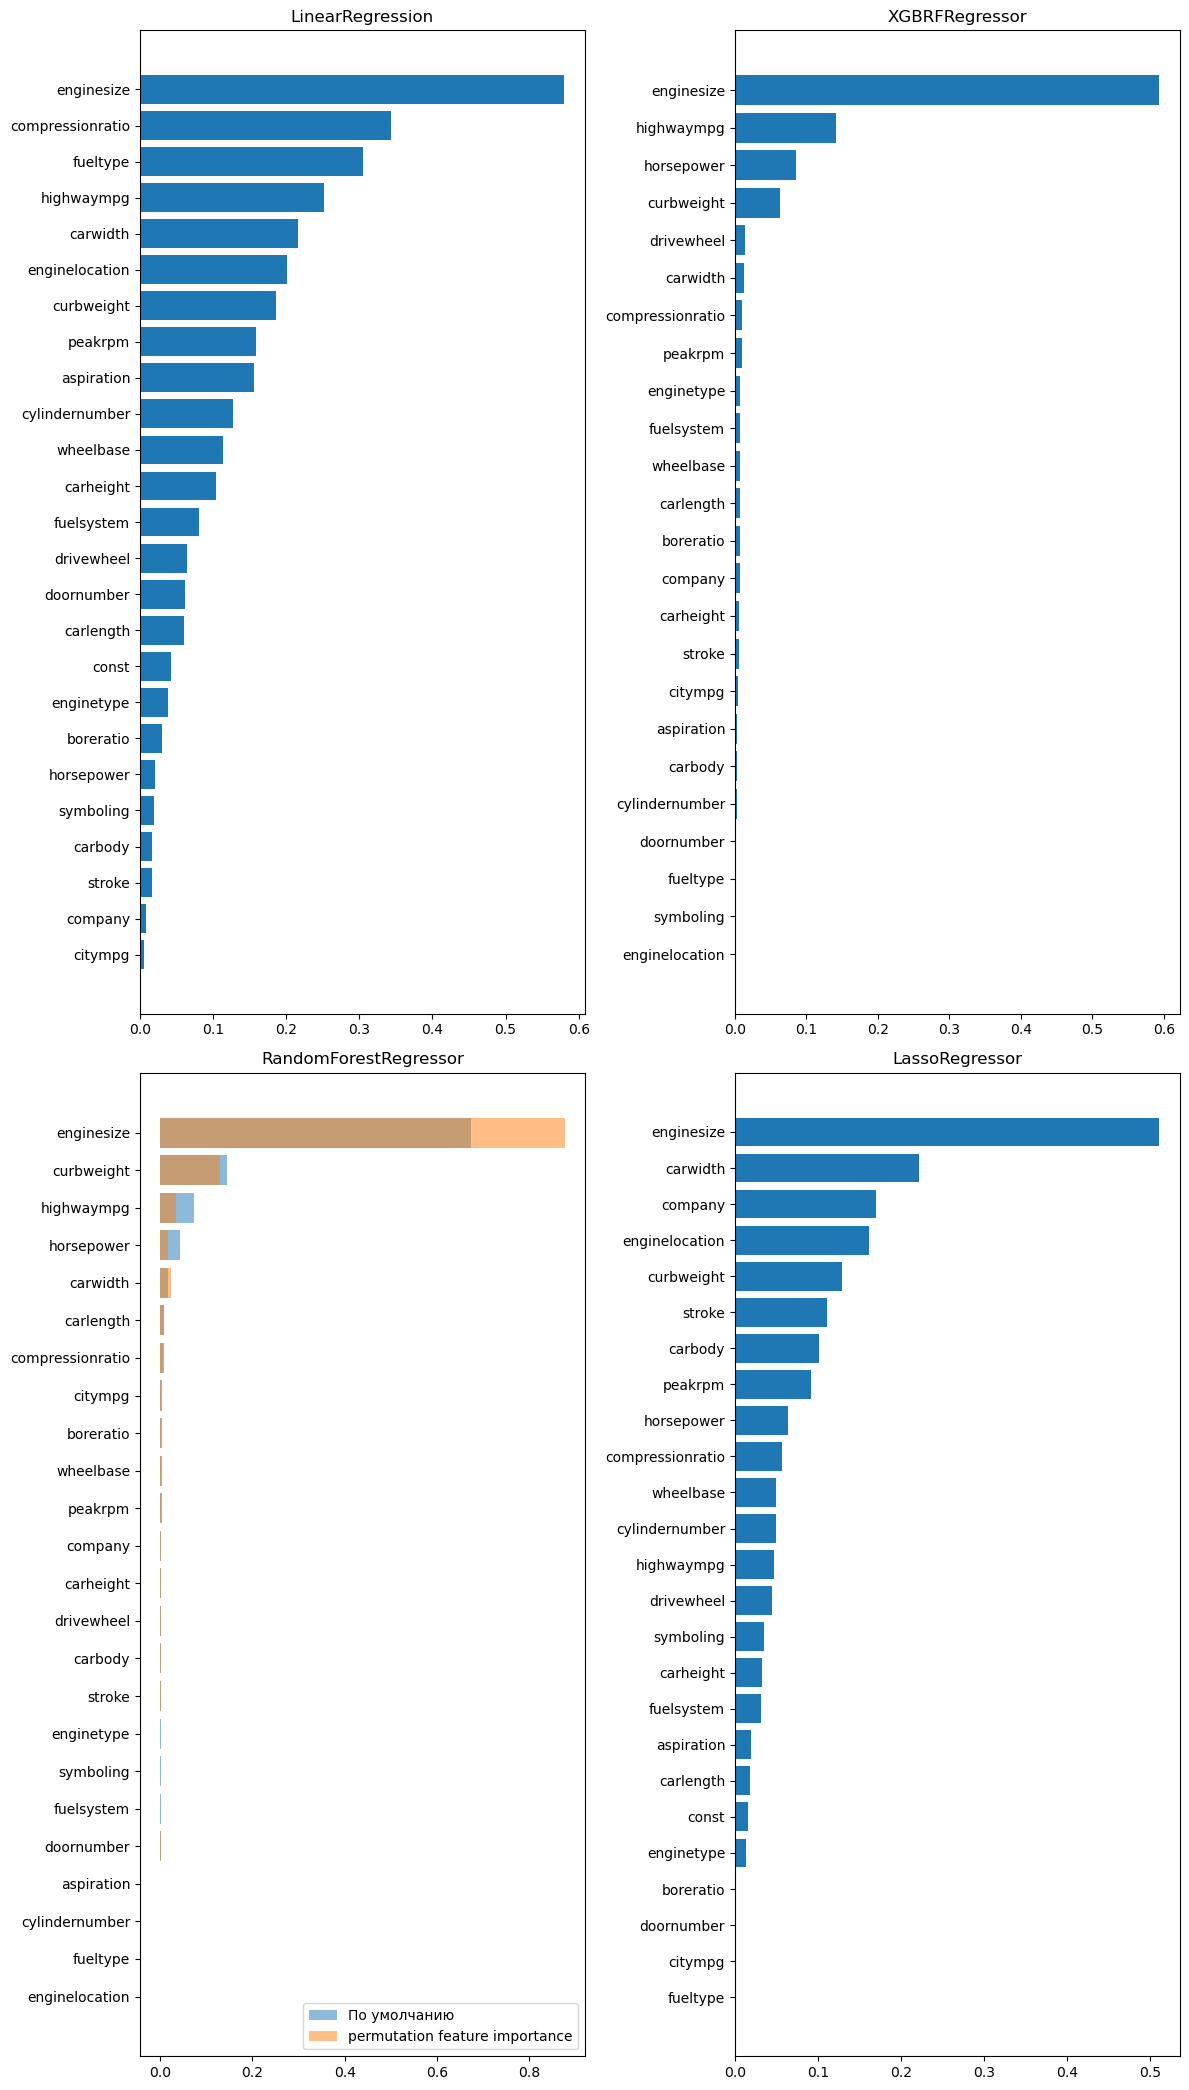

In [48]:
fig , ax = plt.subplots(2,2, figsize = (12,21))

ax[0][0].set_title('LinearRegression')
ax[0][0].barh(list(res.params.sort_values().keys()), abs(res.params).sort_values())

ax[0][1].set_title('XGBRFRegressor')
ax[0][1].barh(list(predictors_model_xdb.sort_values().keys()), predictors_model_xdb.sort_values())

ax[1][0].set_title('RandomForestRegressor')
ax[1][0].barh(list(predictors_forest.sort_values().keys()), predictors_forest.sort_values(), alpha = 0.5, label = 'По умолчанию')
ax[1][0].barh(list(predictors_forest_PI.sort_values().keys()), predictors_forest_PI.sort_values(), alpha = 0.5, label = 'permutation feature importance')
ax[1][0].legend(loc='best')

ax[1][1].set_title('LassoRegressor')
ax[1][1].barh(list(lasso_param.sort_values().keys()), lasso_param.sort_values())

fig.tight_layout()
plt.show()

In [49]:
all_models = pd.concat([predictors_model_xdb,predictors_forest], axis = 1)
all_models.rename(columns = {0:'XGBRFRegressor',1:'RandomForest'}, inplace = True)
all_models.sort_values(by = 'XGBRFRegressor', inplace=True)

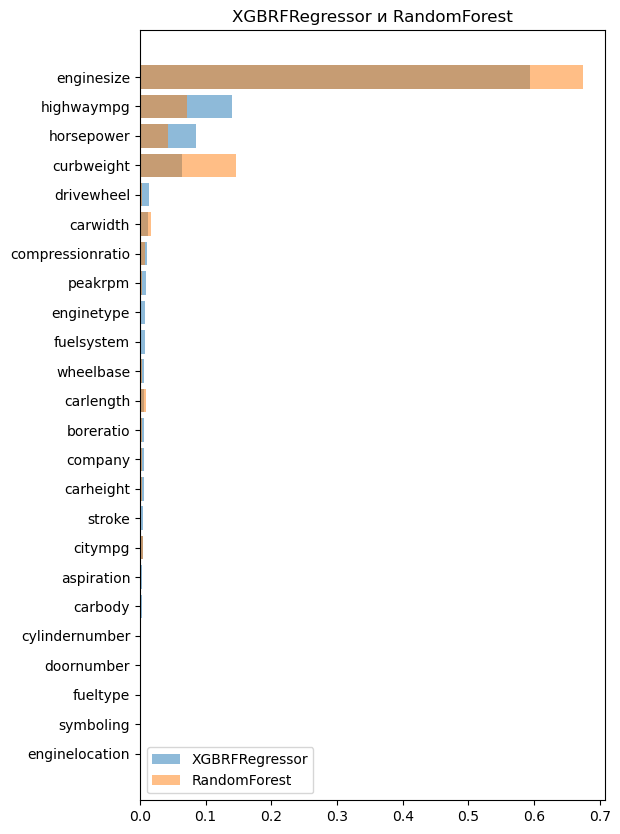

In [50]:
plt.figure(figsize=(6,10))
plt.barh(list(all_models.sort_values(by = 'XGBRFRegressor').index), all_models.sort_values(by = 'XGBRFRegressor').XGBRFRegressor.values, label = 'XGBRFRegressor', alpha = 0.5)
plt.barh(list(all_models.sort_values(by = 'XGBRFRegressor').index), all_models.sort_values(by = 'XGBRFRegressor').RandomForest.values, label = 'RandomForest', alpha = 0.5)
plt.title('XGBRFRegressor и RandomForest')
plt.legend()
plt.show()

### Еще один способ для оценки значимости признаков - это Shapley values.
## Значения SHAP для оценки значимости

Для того чтобы узнать, как значения того или иного признака влияют на решение модели, было предложено использовать shap-значения.Подход SHAP (Shapley additive explanation values) позволяет оценивать важность признаков в произвольных моделях машинного обучения. 

Изначально понятие значений Шепли (Shapley values) было введено в теории игр для распределения выигрыша между игроками.
Значения Шепли позволяют численно оценивать вклад каждого игрока при игре в кооперативную игру (группа игроков действует совместно) для достижения общей цели. 

<img src="Для SHAP.png" alt="drawing" width="400"/>

Например, есть 3 игрока. 
Все 3 игрока вместе в одной команде приносят выигрышь100. Круг приносит выигрыш 20, если добавим к команде квадрат, выигрыш будет 60, ну и если еще будет в команде треугольник, то выигрыш будет 100. Нужно понять, какой игрок делает наибольший вклад в выигрыш. Аналогично происходит и с признаками.

<img src="Для SHAP 2.png" alt="drawing" width="700"/>

Итоговое значение зависит от порядка, в котором игрок вошел в игру. Поэтому делаются все возможные перестановки? и для них считается разница выигрыша между тем моментом, когда игрок только присоединился к команде и тем моментом, когда его еще не было. Полученные значения усредняются.
То есть  мы считаем средний прирост эффективности от добавления игрока i в команду игроков, стоящих перед ним, по всем возможным упорядочиваниям игроков.

В машинном обучении игроки – это признаки, и выигрыш – это величина предсказания модели.
Для того чтобы имитировать отсутствие признака, его заменяют случайными значениями из распределения признаков. То есть просто портят его.

Например, если мы возьмем один объект из выборки, предскажем для него таргет T1 на признаках, где нет проверяемого признака, а затем найдем таргет T2 по модели, где этот признак есть. Найдем разницу между T2 и T1 и получим вклад признака в величину предсказания модели. То есть рассматривается не вклад каждого признака в точность модели, а вклад каждого признака в величину предсказания модели на конкретном примере, что помогает интерпретировать это предсказание. 

С практической точки зрения значения Шепли (из библиотеки shap) могут применяться для признаков табличных данных (показывают, как значения каждого признака влияют на предсказания), при работе с текстами (например, могут применяться для исследования влияния слов при классификации текстов по эмоциональному окрасу) и изображениями (значения Шепли будут показывать, как повлиял на принятие решения моделью тот или иной пиксель изображения).

Положительные значения означают «положительное» влияние на прогноз, отрицательные значения — «отрицательное» влияние на прогноз. 

При изучении данного метода могут периодически возникать вопросы, а действительно ли значения Шепли можно считать мерой важности признаков в модели? Такой вопрос возникает из-за того, что SHAP-значения зависят не только от модели, но и от распределения данных, при этом даже признаки, которые никак не используются моделью, могут иметь ненулевые значения Шепли.

In [51]:
#explainer = shap.explainers.Linear(model_linear_regression, X_train)

explainer = shap.Explainer(model_xdb)
shap_values = explainer(X_train)

Визуализация всех SHAP‑значений для каждого признака. По оси x этой диаграммы SHAP‑значения сгруппированы по признакам.

Каждая точка представляет собой одно SHAP-значение для предсказания и конкретного признака. Красный цвет точки соответствует высокой ценности объекта, синий — низкой. На основе распределения красных и синих точек мы можем получить представление о влиянии значений каждого конкретного признака.

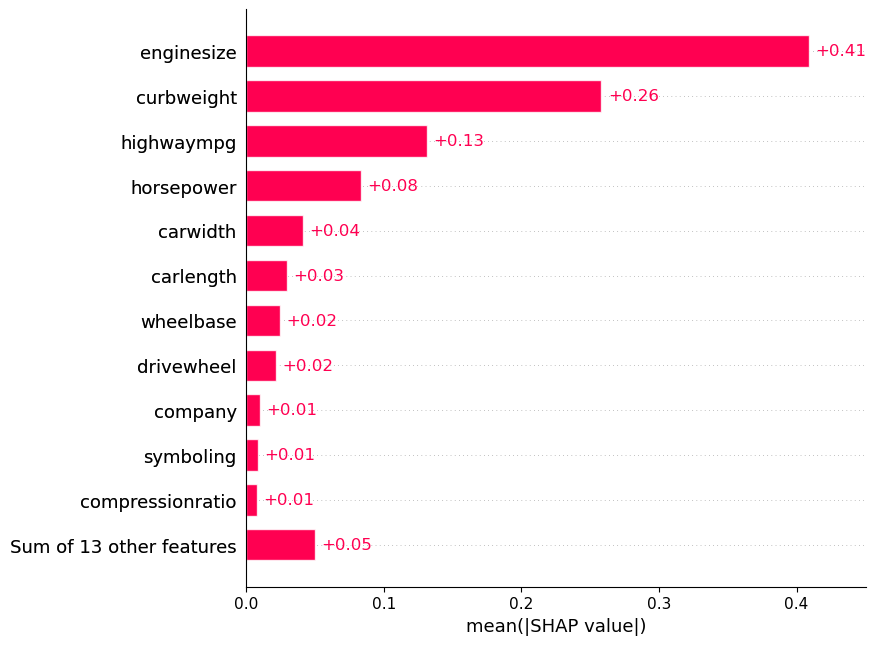

In [52]:
#plt.figure(dpi = 400)
shap.plots.bar(shap_values, max_display=12) #max_display=len(X_train.columns)

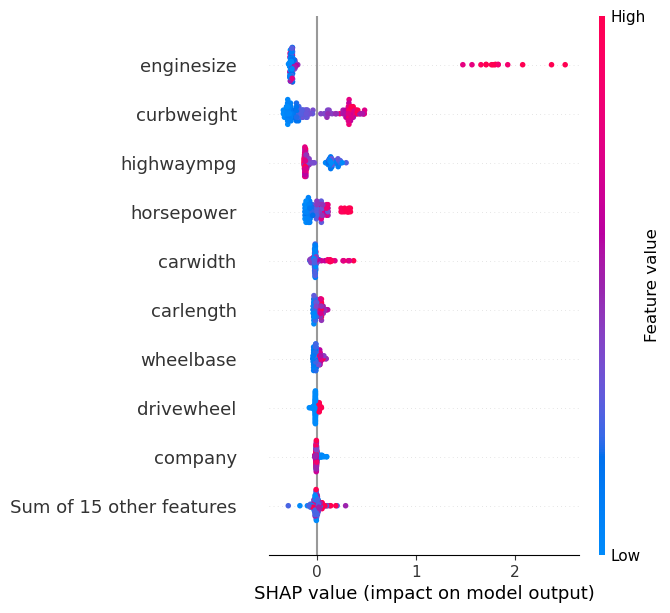

In [54]:
shap.plots.beeswarm(shap_values,plot_size=[5,7]) # max_display=

Исследуя SHAP‑значения на этой диаграмме, мы можем начать понимать природу взаимоотношений между признаками и спрогнозированными ценами на автомобили. Например, в случае с признаком Carbweight, видно, что SHAP‑значения растут по мере роста значения признака. Это указывает на то, что более высокие значения Carbweight соответствуют более высоким спрогнозированным ценам автомобилей.

Видна тут и обратная ситуация, связанная с признаком highwaympg. Здесь — чем меньше значение признака — тем больше SHAP‑значения. Это наблюдение указывает на то, что низкие значения highwaympg связаны с более высокой спрогнозированной стоиомостью автомобиля.

Так же можно посмотреть степень влияния разных предикторов на целевую переменную для конкретного случая

In [55]:
shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values.values[8, :], X_train.iloc[8])

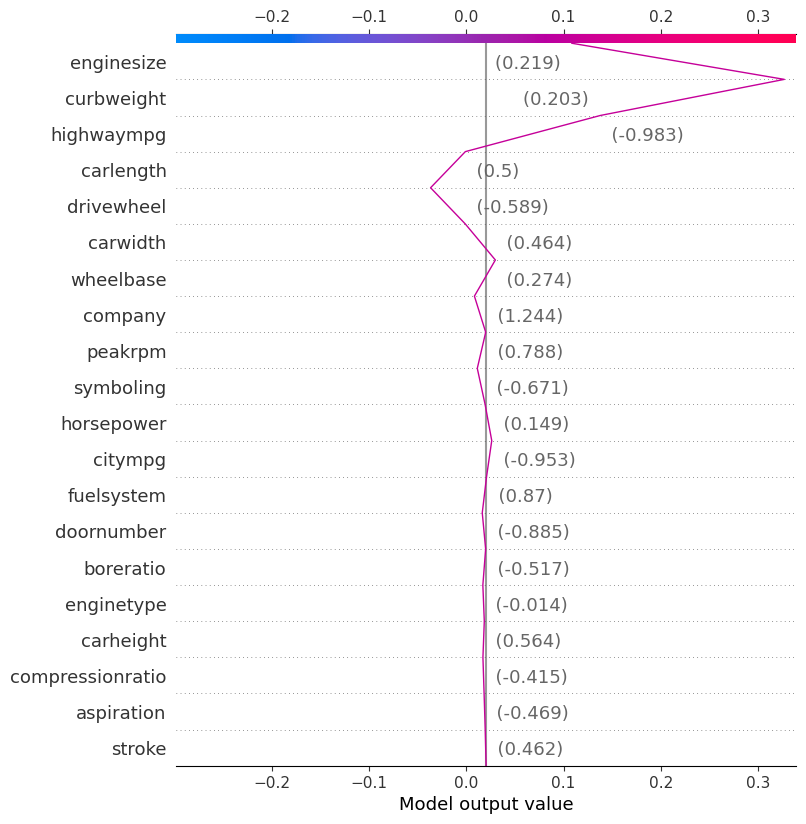

In [56]:
shap.decision_plot(explainer.expected_value, shap_values.values[8, :], X_train.iloc[8])

## Понижение размерности
### Метод случайных проекций
Один из основных подходов к понижению размерности — это линейный подход, в котором каждый новый признак представляет собой линейную комбинацию исходных признаков. Основная идея случайной проекции основывается на лемме Джонсона-Линденштрауса, которая утверждает, что если точки в пространстве имеют достаточно высокую размерность, то они могут быть спроецированы в подходящее пространство более низкой размерности таким образом, чтобы приблизительно сохранять расстояния между точками.

При этом, если необходимо, чтобы расстояния изменились не больше, чем на 𝜀, то размерность нового признакового пространство должна удовлетворять условию 

$$d > \frac{8ln(n)}{𝜀^2}()$$

где n — количество объектов в выборке.

Если использовать d, соответствующее описанной выше формуле, то даже метод случайных проекций так понижает размерность выборки, что расстояния сохраняются неплохо, и это понижение оказывается качественным.

То есть мы выбираем d признаков, которые составляем из случайной линейной комбинации старых признаков.
Значение нового признака для объекта выражается через значения старых признаков этого объекта со случайными весами w.

Один из простейших подходов к такому понижению размерности — это метод случайных проекций, в котором веса генерируются случайно, например, из нормального распределения.

## PCA для выявления признаков

Метод главных компонент — один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков, один из самых эффективных способов устранения мультиколлинеарности. 

В рамках метода делается два важных упрощения задачи:
Игнорируется целевая переменная, мы смотрим только на пространство входных признаков
Строится линейное преобразование исходных признаков, сохраняющее большую часть доступной информации.

Под информацией понимается дисперсия, рассчитанная вдоль некоторого вектора в признаковом пространстве (признака).

Задачу метода главных компонент можно вывести из линейного подхода к понижению размерности, где каждый новый признак линейно выражается через исходные.

In [57]:
X_train_for_pca = X_train.copy()
X_test_for_pca = X_test.copy()

In [58]:
metrics = dict()
for n in range (5, len(X_train.columns)-1):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_for_pca)
    X_test_pca = pca.transform(X_test_for_pca)
    
    model_linear_regression = LinearRegression()
    model_linear_regression.fit(X_train_pca, y_train)
    
    metrics[n] = score(X_test_pca,y_test,model_linear_regression)

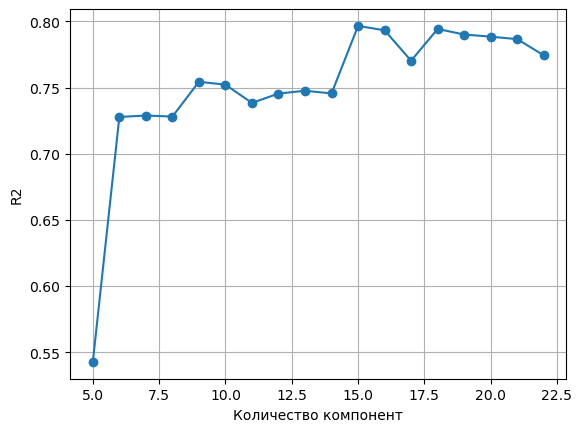

Лучший R2 : 0.7966 для 15 компонент


In [59]:
plt.grid()
plt.plot(metrics.keys(),metrics.values(), '-o')
plt.ylabel('R2')
plt.xlabel('Количество компонент')
plt.show()


print(f'Лучший R2 : {metrics[max(metrics, key=metrics.get)]} для {max(metrics, key=metrics.get)} компонент')

## Результат

In [60]:
shap_features = pd.Series(np.abs(shap_values.values).mean(0), index=shap_values.feature_names)

In [61]:
predictors_model_xdb.sort_values(inplace = True)

shap_features.sort_values(inplace = True)

predictors_forest.sort_values(inplace = True)

predictors_forest_PI.sort_values(inplace = True)

lasso_param.sort_values(inplace = True)

res_p.sort_values(inplace = True, ascending=False)

In [62]:
xdb = pd.Series(sorted(predictors_model_xdb[-12:].index))
forest = pd.Series(sorted(predictors_forest[-12:].index))
forest_PI = pd.Series(sorted(predictors_forest_PI[-12:].index))
lasso = pd.Series(sorted(lasso_param[-12:].index))
linear = pd.Series(sorted(res_p[-12:].index))
pirson = pd.Series(sorted(features_lin[-12:].index))
MI = pd.Series(sorted(features_MI[-12:].index))
ADD = pd.Series(sorted(sfs_forward_feat))
DELL = pd.Series(sorted(sfs_backward_feat))
shap = pd.Series(sorted(shap_features[-12:].index))

In [63]:
all_methods = set(xdb) & set(forest) & set(forest_PI) & set(lasso) & set(linear) & set(pirson) & set(MI) & set(ADD) & set(DELL) & set(shap)

In [64]:
result = pd.concat([xdb, forest,forest_PI,lasso,linear,pirson,MI,ADD,DELL,shap], axis = 1,
                  keys = ['Бустинг', 'Случайный лес','Permut. feature importance','Lasso','Linear','Pirson','Mutual info','ADD','DELL','Shap-values'])

#### Табличка топ 12 самых важных признаков, которые выделили разные алгоритмы

In [65]:
result

,Бустинг,Случайный лес,Permut. feature importance,Lasso,Linear,Pirson,Mutual info,ADD,DELL,Shap-values
0,carlength,boreratio,carheight,carbody,aspiration,boreratio,boreratio,aspiration,aspiration,carbody
1,carwidth,carlength,carlength,carwidth,carbody,carlength,carheight,carbody,carbody,carlength
2,compressionratio,carwidth,carwidth,company,carwidth,carwidth,carlength,carwidth,carheight,carwidth
3,curbweight,citympg,citympg,compressionratio,citympg,citympg,carwidth,company,carwidth,company
4,drivewheel,company,company,curbweight,company,curbweight,citympg,compressionratio,citympg,compressionratio
5,enginesize,compressionratio,compressionratio,cylindernumber,curbweight,drivewheel,curbweight,curbweight,company,curbweight
6,enginetype,curbweight,curbweight,enginelocation,cylindernumber,enginelocation,enginesize,enginelocation,compressionratio,drivewheel
7,fuelsystem,enginesize,doornumber,enginesize,enginelocation,enginesize,fuelsystem,enginesize,enginelocation,enginesize
8,highwaympg,highwaympg,drivewheel,horsepower,enginesize,fuelsystem,highwaympg,fueltype,enginesize,highwaympg
9,horsepower,horsepower,enginesize,peakrpm,highwaympg,highwaympg,horsepower,peakrpm,peakrpm,horsepower


#### Все методы отбора признаков считают, что важными признаками являются carwidth и enginesize, почти везде встречаются признаки: enginlocation, carlength, highwaympg, horsepower.